# Clear sky temperature example


This juypter notebook is intended to demonstrate the clear sky temperature model




In [4]:
from rdtools import clearsky_temperature
import pvlib

import pandas as pd
from datetime import datetime, timedelta


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

#  <b>Standardize</b>

Please download the site data from Site 5, and unzip the csv file in the folder:
./rdtools/docs/

http://dkasolarcentre.com.au/historical-data/download

The following script loads the data, parses a pandas.DateTimeIndex, and renames the critical pandas.Series objects.



In [5]:
file_name = '89-Site_5-Kyocera.csv'

df_raw = pd.DataFrame.from_csv(file_name, index_col=0, parse_dates=True)

df = pd.DataFrame()
df['ac power'] = df_raw.iloc[:,2]
df['ghor'] = df_raw.iloc[:,8]
df['tamb'] = df_raw.iloc[:,6]
df['wsp'] = df_raw.iloc[:,5]

# downsample, degradation_year_on_year does not currently support 5-minute data
df = df.asfreq('15T')

# <b>Set metadata and run models</b>


1. get clear sky ambient temperature from rdtools

2. get clear sky irradiance from pvlib

3. compute cell temperature from sensor data

4. compute clear sky cell temperature from modeled data

In [6]:
#set site metadata
meta = {"altitude":0,
       "latitude": -23.761878,
       "longitude": 133.874846,
       "Name": "Alice Springs",
       "State": "n/a",
       "TZ": 8.5,
       "temperature_model": 'open_rack_cell_polymerback'}


#setup pvlib objects
loc = pvlib.location.Location(meta['latitude'],meta['longitude']) 
pvsys = pvlib.pvsystem.PVSystem(racking_model=meta['temperature_model'])


#run clear sky temperature model
df['Clear Sky Temperature (deg C)'] = rdtools.clearsky_temperature.get_clearsky_tamb(df.index, meta['latitude'],
                                                                                     meta['longitude'], meta['TZ'])


#run clear sky irradiance model
df['Clear Sky Irradiance (W/cm2)'] = loc.get_clearsky(df.index-timedelta(hours=meta['TZ']))['ghi'].tolist()


#compute cell temperature
df['Cell Temperature (deg C)'] = pvsys.sapm_celltemp(df['ghor'],0,df['tamb'])['temp_cell']


#compute clear sky cell temperature
df['Clear Sky Cell Temperature (deg C)'] = pvsys.sapm_celltemp(df['Clear Sky Irradiance (W/cm2)'],0,
                                                               df['Clear Sky Temperature (deg C)'])['temp_cell']

C:\Users\gkimball\Envs\env_ecmwf\lib\site-packages\pvlib\atmosphere.py:215: RuntimeWarning: invalid value encountered in power
  0.50572*(((6.07995 + (90 - z)) ** - 1.6364))))
C:\Users\gkimball\Envs\env_ecmwf\lib\site-packages\pvlib\clearsky.py:126: RuntimeWarning: invalid value encountered in fmax
  ghi = cg1 * dni_extra * cos_zenith * tl / tl * np.fmax(ghi, 0)
C:\Users\gkimball\Envs\env_ecmwf\lib\site-packages\pvlib\clearsky.py:131: RuntimeWarning: invalid value encountered in fmax
  bnci = dni_extra * np.fmax(bnci, 0)


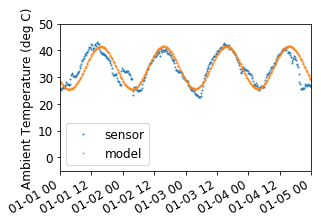

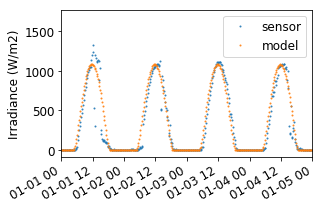

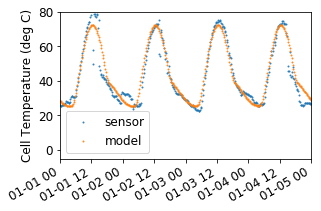

In [7]:
# plot the temperature time series
fig, ax = plt.subplots()
ax.plot(df.index, df['tamb'], 'o', alpha = 0.9, label='sensor')
ax.plot(df.index, df['Clear Sky Temperature (deg C)'], 'o', alpha = 0.9, label='model')
ax.legend()
ax.set_ylim(-5,50)
fig.autofmt_xdate()
ax.set_xlim(datetime(2012,1,1), datetime(2012,1,5))
ax.set_ylabel('Ambient Temperature (deg C)')


fig, ax = plt.subplots()
ax.plot(df.index, df['ghor'], 'o', alpha = 0.9, label='sensor')
ax.plot(df.index, df['Clear Sky Irradiance (W/cm2)'], 'o', alpha = 0.9, label='model')
ax.legend()
fig.autofmt_xdate()
ax.set_xlim(datetime(2012,1,1), datetime(2012,1,5))
ax.set_ylabel('Irradiance (W/m2)');


fig, ax = plt.subplots()
ax.plot(df.index, df['Cell Temperature (deg C)'], 'o', alpha = 0.9, label='sensor')
ax.plot(df.index, df['Clear Sky Cell Temperature (deg C)'], 'o', alpha = 0.9, label='model')
ax.legend()
ax.set_ylim(-5,80)
fig.autofmt_xdate()
ax.set_xlim(datetime(2012,1,1), datetime(2012,1,5))
ax.set_ylabel('Cell Temperature (deg C)');